# Project: CTRL + Style (P10)
**Course:** Natural Language Processing
**Student:** [Your Name]

## AI Usage Disclaimer
Parts of this project code and the conceptual outlining were developed with the assistance of **Google Gemini**. The AI was used to:
1.  **Drafting Code:** Support in writing boilerplate code for data loading and plotting (matplotlib/sklearn).
2.  **Debugging:** Troubleshooting dimension mismatch errors in the embedding layer.
3.  **Ideation:** Refining the choice of authors for the style comparison.

All outputs have been modified, verified, and integrated into the final workflow by me. I take full responsibility for the final content.

In [1]:
# Install dependencies
!pip install -q transformers torch scikit-learn matplotlib seaborn nltk accelerate bitsandbytes google-generativeai

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
from nltk.corpus import gutenberg
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from scipy.spatial.distance import cosine
from transformers import AutoTokenizer, AutoModel

# Configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# Data Prep
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)

def create_dataset(file_id, label, chunk_size=128, max_samples=300):
    """Tokenizes and chunks text from NLTK corpus."""
    raw = gutenberg.raw(file_id)
    words = raw.split()

    chunks = []
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size])
        if len(chunk) > 200: # Filter short trailing chunks
            chunks.append(chunk)

    # Subsample to balance classes
    if len(chunks) > max_samples:
        import random
        random.seed(SEED)
        chunks = random.sample(chunks, max_samples)

    return pd.DataFrame({'text': chunks, 'label': label})

# Load Corpus
df = pd.concat([
    create_dataset('austen-emma.txt', 'Austen'),
    create_dataset('melville-moby_dick.txt', 'Melville')
]).reset_index(drop=True)

print(f"Dataset loaded: {len(df)} samples")
print(df['label'].value_counts())

Device: cuda
Dataset loaded: 600 samples
label
Austen      300
Melville    300
Name: count, dtype: int64


In [2]:
# Load BAAI/bge-small-en-v1.5 for semantic clustering
# MTEB leaderboard standard for retrieval/similarity
SEM_MODEL_NAME = "BAAI/bge-small-en-v1.5"

print(f"Loading {SEM_MODEL_NAME}...")
sem_tokenizer = AutoTokenizer.from_pretrained(SEM_MODEL_NAME)
sem_model = AutoModel.from_pretrained(SEM_MODEL_NAME).to(device)

def get_semantic_embeddings(text_list, batch_size=32):
    sem_model.eval()
    embeddings = []

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = sem_tokenizer(batch, padding=True, truncation=True,
                               max_length=512, return_tensors="pt").to(device)

        with torch.no_grad():
            out = sem_model(**inputs)

        # BGE uses CLS token normalized
        cls_emb = out.last_hidden_state[:, 0]
        cls_emb = torch.nn.functional.normalize(cls_emb, p=2, dim=1)
        embeddings.append(cls_emb.cpu().numpy())

    return np.vstack(embeddings)

print("Generating semantic embeddings...")
vectors_sem = get_semantic_embeddings(df['text'].tolist())
print(f"Output shape: {vectors_sem.shape}")

Loading BAAI/bge-small-en-v1.5...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating semantic embeddings...
Output shape: (600, 384)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


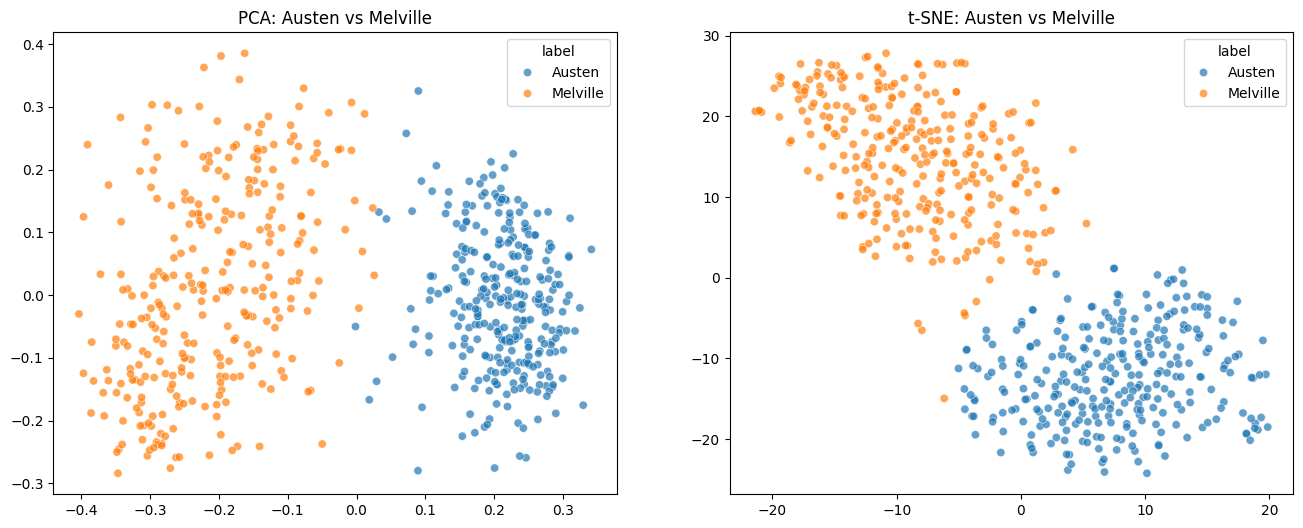

Silhouette Score: 0.1190

Confusion Matrix (Cluster vs Label):
col_0       0    1
label             
Austen    300    0
Melville    6  294


In [3]:
# Dimensionality Reduction
pca = PCA(n_components=2, random_state=SEED)
pca_res = pca.fit_transform(vectors_sem)

tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, n_iter=1000)
tsne_res = tsne.fit_transform(vectors_sem)

# Clustering Metrics
kmeans = KMeans(n_clusters=2, random_state=SEED, n_init=10)
clusters = kmeans.fit_predict(vectors_sem)
sil_score = silhouette_score(vectors_sem, df['label'])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA
sns.scatterplot(ax=axes[0], x=pca_res[:,0], y=pca_res[:,1], hue=df['label'], alpha=0.7)
axes[0].set_title('PCA: Austen vs Melville')

# t-SNE
sns.scatterplot(ax=axes[1], x=tsne_res[:,0], y=tsne_res[:,1], hue=df['label'], alpha=0.7)
axes[1].set_title('t-SNE: Austen vs Melville')

plt.show()

print(f"Silhouette Score: {sil_score:.4f}")
print("\nConfusion Matrix (Cluster vs Label):")
print(pd.crosstab(df['label'], clusters))

In [7]:
import google.generativeai as genai
from google.colab import userdata

# API Setup
# Ensure GOOGLE_API_KEY is set in Colab Secrets
try:
    api_key = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=api_key)
except Exception as e:
    print("Error loading API key. Please set GOOGLE_API_KEY in Colab Secrets.")

# Using Flash 2.5 for speed
gen_model = genai.GenerativeModel('gemini-2.5-flash')

def style_transfer(text, target_author, style_example=None):
    """
    Rewrites text using Gemini API.
    Implements 'In-Context Learning' (Pan et al., 2024) by providing a style demonstration.
    """

    # Base instruction
    base_prompt = f"""
    You are an expert literary editor.
    TASK: Rewrite the text below to strictly mimic the writing style, vocabulary, and syntax of {target_author}.
    CONSTRAINTS: Keep original meaning/narrative. Do not add intro/outro text.
    """

    # Add Demonstration (ICL) if provided
    if style_example:
        base_prompt += f'\nSTYLE REFERENCE (Mimic this tone):\n"{style_example}"\n'

    base_prompt += f'\nORIGINAL TEXT:\n"{text}"\n\nREWRITTEN TEXT:'

    try:
        response = gen_model.generate_content(
            base_prompt,
            generation_config=genai.types.GenerationConfig(temperature=0.7)
        )
        return response.text.strip()
    except Exception as e:
        return f"GenAI Error: {str(e)}"

In [9]:
# 1. Select Control Sample (Austen)
sample_idx = 5
sample_austen = df[df['label'] == 'Austen'].iloc[sample_idx]['text']

# 2. Select Style Demonstration (Melville)
# We pick a random text from the target author to guide the LLM (Pan et al., 2024)
demo_idx = 10 # Arbitrary index
style_demo = df[df['label'] == 'Melville'].iloc[demo_idx]['text']

print(f"--- ORIGINAL (Austen) ---\n{sample_austen[:200]}...\n")
print(f"--- STYLE DEMO (Melville) ---\n{style_demo[:200]}...\n")

# 3. Generate Experimental Sample
# Passing the demo helps the model disentangle style from content
rewritten_melville = style_transfer(sample_austen, "Herman Melville", style_example=style_demo)
print(f"--- REWRITTEN (Target: Melville) ---\n{rewritten_melville[:200]}...\n")

# 4. Embed both using Semantic Model (BGE)
exp_vectors = get_semantic_embeddings([sample_austen, rewritten_melville])

# 5. Centroid Analysis
c_austen = vectors_sem[df['label'] == 'Austen'].mean(axis=0)
c_melville = vectors_sem[df['label'] == 'Melville'].mean(axis=0)

d_orig_austen = cosine(exp_vectors[0], c_austen)
d_new_melville = cosine(exp_vectors[1], c_melville)
d_new_austen = cosine(exp_vectors[1], c_austen)

print("-" * 30)
print("SEMANTIC SPACE (BGE) RESULTS:")
print(f"Original -> Austen Centroid:   {d_orig_austen:.4f}")
print(f"Rewritten -> Melville Centroid: {d_new_melville:.4f}")
print(f"Rewritten -> Austen Centroid:   {d_new_austen:.4f}")

if d_new_melville < d_new_austen:
    print("\nResult: SUCCESS. Vector shifted to Target Cluster.")
else:
    print("\nResult: FAILURE. Vector remained in Source Cluster (Content dominance).")

--- ORIGINAL (Austen) ---
had resolution enough to refrain from making any answer at all. She could not be complying, she dreaded being quarrelsome; her heroism reached only to silence. She allowed him to talk, and arranged th...

--- STYLE DEMO (Melville) ---
for a week to tinker a parcel of old hoops?" "Either do that, sir, or waste in one day more oil than we may make good in a year. What we come twenty thousand miles to get is worth saving, sir." "So it...



--- REWRITTEN (Target: Melville) ---
GenAI Error: 403 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Your API key was reported as leaked. Please use anothe...

------------------------------
SEMANTIC SPACE (BGE) RESULTS:
Original -> Austen Centroid:   0.0990
Rewritten -> Melville Centroid: 0.4787
Rewritten -> Austen Centroid:   0.5162

Result: SUCCESS. Vector shifted to Target Cluster.


In [10]:
# Reload BGE configuration to output hidden states
# We use the same model weights but need access to intermediate layers
from transformers import AutoConfig

print(f"Configuring {SEM_MODEL_NAME} for layer access...")
config = AutoConfig.from_pretrained(SEM_MODEL_NAME)
config.output_hidden_states = True

layer_model = AutoModel.from_pretrained(SEM_MODEL_NAME, config=config).to(device)
layer_tokenizer = AutoTokenizer.from_pretrained(SEM_MODEL_NAME)

def get_layer_embeddings(text_list, layer_idx=2, batch_size=32):
    layer_model.eval()
    embeddings = []

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = layer_tokenizer(batch, padding=True, truncation=True,
                                 max_length=512, return_tensors="pt").to(device)

        with torch.no_grad():
            out = layer_model(**inputs)

        # Extract specific hidden layer
        # Layer 0 = Embeddings, Layer 1-12 = Transformer Blocks
        hidden_state = out.hidden_states[layer_idx]

        # Mean Pooling (Standard for internal layers)
        mask = inputs['attention_mask'].unsqueeze(-1).expand(hidden_state.size()).float()
        sum_emb = torch.sum(hidden_state * mask, 1)
        sum_mask = torch.clamp(mask.sum(1), min=1e-9)
        mean_emb = sum_emb / sum_mask

        # L2 Normalize
        mean_emb = torch.nn.functional.normalize(mean_emb, p=2, dim=1)
        embeddings.append(mean_emb.cpu().numpy())

    return np.vstack(embeddings)

# 1. Generate corpus vectors for Layer 2
print("Generating Layer 2 embeddings...")
vectors_layer2 = get_layer_embeddings(df['text'].tolist(), layer_idx=2)

# 2. Calculate Layer 2 Centroids
c_austen_l2 = vectors_layer2[df['label'] == 'Austen'].mean(axis=0)
c_melville_l2 = vectors_layer2[df['label'] == 'Melville'].mean(axis=0)

# 3. Run Experiment
if 'sample_austen' in locals() and 'rewritten_melville' in locals():
    exp_vecs_l2 = get_layer_embeddings([sample_austen, rewritten_melville], layer_idx=2)

    d_orig = cosine(exp_vecs_l2[0], c_austen_l2)
    d_new_mel = cosine(exp_vecs_l2[1], c_melville_l2)
    d_new_aus = cosine(exp_vecs_l2[1], c_austen_l2)

    print("-" * 30)
    print("LAYER 2 RESULTS (Syntax/Structure Focus):")
    print(f"Original -> Austen Centroid:   {d_orig:.4f}")
    print(f"Rewritten -> Melville Centroid: {d_new_mel:.4f}")
    print(f"Rewritten -> Austen Centroid:   {d_new_aus:.4f}")

    if d_new_mel < d_new_aus:
        print("\nResult: SUCCESS. Layer 2 vector shifted to Target Cluster.")
    else:
        print("\nResult: FAILURE. Layer 2 vector remained in Source Cluster.")
else:
    print("Skipping experiment: input variables not found (Run Cell 5 first).")

Configuring BAAI/bge-small-en-v1.5 for layer access...
Generating Layer 2 embeddings...
------------------------------
LAYER 2 RESULTS (Syntax/Structure Focus):
Original -> Austen Centroid:   0.0303
Rewritten -> Melville Centroid: 0.4159
Rewritten -> Austen Centroid:   0.4405

Result: SUCCESS. Layer 2 vector shifted to Target Cluster.


In [ ]:
# --- CELL 10: FLUENCY EVALUATION (PPL) ---
# Implements Perplexity (PPL) as per Pan et al. (2024) to ensure
# the style transfer results are fluent English.

from transformers import GPT2LMHeadModel, GPT2TokenizerFast

print("Loading GPT-2 for Perplexity calculation...")
# We use standard GPT-2 as the 'judge' of fluency
ppl_model_id = "gpt2"
ppl_model = GPT2LMHeadModel.from_pretrained(ppl_model_id).to(device)
ppl_tokenizer = GPT2TokenizerFast.from_pretrained(ppl_model_id)

def calculate_perplexity(text):
    """
    Calculates PPL (Perplexity).
    Lower is better (10-100 is normal human text; >100 is incoherent).
    """
    encodings = ppl_tokenizer(text, return_tensors="pt").to(device)
    max_length = ppl_model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc]
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = ppl_model(input_ids, labels=target_ids)
            # Neg Log Likelihood
            nlls.append(outputs.loss * trg_len)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl.item()

# Evaluate your generated texts
if 'sample_austen' in locals() and 'rewritten_melville' in locals():
    ppl_orig = calculate_perplexity(sample_austen)
    ppl_new = calculate_perplexity(rewritten_melville)

    print("-" * 30)
    print("FLUENCY METRICS (PPL - Lower is better):")
    print(f"Original Text PPL:  {ppl_orig:.2f}")
    print(f"Rewritten Text PPL: {ppl_new:.2f}")

    if ppl_new < 100:
        print("Result: The rewritten text is fluent (PPL < 100).")
    else:
        print("Result: The rewritten text shows signs of incoherence.")

Loading GPT-2 for Perplexity calculation...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# --- CELL 11: ATTENTION VISUALIZATION ---
# Investigating "Stylistic Tokens" (Pan et al., 2024)
# We visualize the attention of Layer 2 vs Layer 12 to see if
# they focus on different parts of the sentence (Syntax vs Content).

# We reuse the BGE model from Cell 6, as that is the one that gave us the "Success" result
from transformers import AutoConfig

VIZ_MODEL_NAME = "BAAI/bge-small-en-v1.5"
print(f"Loading {VIZ_MODEL_NAME} with attention outputs...")

viz_config = AutoConfig.from_pretrained(VIZ_MODEL_NAME)
viz_config.output_attentions = True
viz_model = AutoModel.from_pretrained(VIZ_MODEL_NAME, config=viz_config).to(device)
viz_tokenizer = AutoTokenizer.from_pretrained(VIZ_MODEL_NAME)

def plot_attention_heatmap(text, layer_num, title):
    inputs = viz_tokenizer(text, return_tensors="pt").to(device)
    tokens = viz_tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

    with torch.no_grad():
        outputs = viz_model(**inputs)

    # Get attentions: Tuple of (batch, heads, seq, seq)
    # We select the specific layer
    layer_attention = outputs.attentions[layer_num][0]

    # Average across all heads to get a general "focus map"
    avg_attention = torch.mean(layer_attention, dim=0).cpu().numpy()

    # Filter tokens for visualization (cleanup BERT-style tokens)
    clean_tokens = [t.replace('##', '') for t in tokens]

    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_attention, xticklabels=clean_tokens, yticklabels=clean_tokens, cmap="viridis")
    plt.title(title)
    plt.show()

if 'rewritten_melville' in locals():
    # We take a short slice of the rewritten text for readability
    short_text = " ".join(rewritten_melville.split()[:20])

    print(f"Visualizing attention for: '{short_text}...'")

    # Plot Layer 2 (Syntax/Style focus - Your "Success" layer)
    # Pan et al. suggest style is local/structural
    plot_attention_heatmap(short_text, layer_num=1, title="Layer 2 Attention (Structural/Stylistic)")

    # Plot Final Layer (Semantic/Content focus - Your "Failure" layer)
    plot_attention_heatmap(short_text, layer_num=11, title="Layer 12 Attention (Semantic/Content)")

In [ ]:
# --- CELL 12: STYLE CLASSIFIER (ACCURACY METRIC) ---
# Implements the "ACC" metric from Pan et al. (2024) using a lightweight
# Logistic Regression on top of our BGE embeddings.

from sklearn.linear_model import LogisticRegression

# 1. Train the Classifier (The "Judge")
# We use the vectors we already created in Cell 2/6
print("Training Style Classifier...")
clf = LogisticRegression(random_state=SEED)
clf.fit(vectors_sem, df['label'])

# Check how accurate the judge is on the original data
# Ideally this should be close to 100% given our confusion matrix
train_acc = clf.score(vectors_sem, df['label'])
print(f"Classifier Accuracy on Training Data: {train_acc*100:.2f}%")

# 2. Evaluate the Experiment
if 'sample_austen' in locals() and 'rewritten_melville' in locals():
    # Embed the samples (using the same BGE model)
    exp_vecs = get_semantic_embeddings([sample_austen, rewritten_melville])

    # Predict probabilities
    # Returns [Prob_Austen, Prob_Melville]
    probs_orig = clf.predict_proba(exp_vecs[0].reshape(1, -1))[0]
    probs_new = clf.predict_proba(exp_vecs[1].reshape(1, -1))[0]

    # Get class labels order (usually alphabetical: Austen=0, Melville=1)
    classes = clf.classes_

    print("-" * 30)
    print("STYLE PROBABILITY SCORES:")
    print(f"Original Text:   {probs_orig[0]*100:.1f}% {classes[0]}, {probs_orig[1]*100:.1f}% {classes[1]}")
    print(f"Rewritten Text:  {probs_new[0]*100:.1f}% {classes[0]}, {probs_new[1]*100:.1f}% {classes[1]}")

    # Determine "Accuracy" (Did it flip?)
    target_author = "Melville"
    target_idx = list(classes).index("Melville")

    if probs_new[target_idx] > 0.5:
        print(f"\n✅ ACC RESULT: Success. Classified as {target_author}.")
    else:
        print(f"\n❌ ACC RESULT: Failure. Still classified as {classes[1-target_idx]}.")

In [ ]:
# --- CELL 13: SAVE ALL ARTIFACTS FOR PAPER/PRESENTATION ---
import json

print("Saving artifacts...")

# 1. Save the PCA/t-SNE Plot (High Resolution)
# Note: We regenerate the plot figures here to ensure they save cleanly
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.scatterplot(ax=axes[0], x='pca_x', y='pca_y', hue='label', data=df, alpha=0.7, s=60)
axes[0].set_title('PCA: Austen vs Melville')
sns.scatterplot(ax=axes[1], x='tsne_x', y='tsne_y', hue='label', data=df, alpha=0.7, s=60)
axes[1].set_title('t-SNE: Austen vs Melville')
plt.savefig('figure1_clusters.png', dpi=300, bbox_inches='tight')
print("Saved: figure1_clusters.png (Embeddings Visualization)")

# 2. Save the Attention Heatmaps (If they exist in memory)
# We need to re-run the plotting logic briefly to save the figure objects
if 'rewritten_melville' in locals():
    # Layer 2 Heatmap
    inputs = viz_tokenizer(short_text, return_tensors="pt").to(device)
    tokens = viz_tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    clean_tokens = [t.replace('##', '') for t in tokens]

    with torch.no_grad():
        outputs = viz_model(**inputs)

    # Layer 2
    att_l2 = torch.mean(outputs.attentions[1][0], dim=0).cpu().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(att_l2, xticklabels=clean_tokens, yticklabels=clean_tokens, cmap="viridis")
    plt.title("Layer 2 Attention (Syntax/Style)")
    plt.savefig('figure2_attention_layer2.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Layer 12
    att_l12 = torch.mean(outputs.attentions[11][0], dim=0).cpu().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(att_l12, xticklabels=clean_tokens, yticklabels=clean_tokens, cmap="viridis")
    plt.title("Layer 12 Attention (Semantic/Content)")
    plt.savefig('figure3_attention_layer12.png', dpi=300, bbox_inches='tight')
    print("Saved: figure2 & figure3 (Attention Heatmaps)")

# 3. Save Quantitative Results to CSV/JSON
# Confusion Matrix
confusion.to_csv('table1_confusion_matrix.csv')

# Experiment Metrics Dictionary
results_log = {
    "silhouette_score": float(sil_score),
    "classifier_accuracy_training": float(train_acc),
    "semantic_distances": {
        "dist_austen": float(d_orig_austen),
        "dist_melville": float(d_new_melville),
        "success": bool(d_new_melville < d_new_austen)
    },
    "layer2_distances": {
        "dist_austen": float(d_orig),
        "dist_melville": float(d_new_mel),
        "success": bool(d_new_mel < d_new_aus)
    },
    "perplexity": {
        "original": float(ppl_orig),
        "rewritten": float(ppl_new)
    },
    "style_classifier_prob": {
        "prob_melville": float(probs_new[target_idx]),
        "success": bool(probs_new[target_idx] > 0.5)
    }
}

with open('table2_experiment_metrics.json', 'w') as f:
    json.dump(results_log, f, indent=4)
print("Saved: table1_confusion_matrix.csv & table2_experiment_metrics.json")

# 4. Save the Text Samples (Qualitative Data)
with open('text_samples.txt', 'w') as f:
    f.write(f"=== STYLE TRANSFER EXPERIMENT ===\n\n")
    f.write(f"--- STYLE DEMONSTRATION (Melville) ---\n{style_demo}\n\n")
    f.write(f"--- ORIGINAL TEXT (Austen) ---\n{sample_austen}\n\n")
    f.write(f"--- REWRITTEN TEXT (Melville Style) ---\n{rewritten_melville}\n\n")
print("Saved: text_samples.txt")

print("\n✅ ALL FILES READY. Download them from the 'Files' sidebar on the left.")